In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, get_data, binarize, normal_kl
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear
from utils.dynamics import Dynamics

In [3]:
x = tf.placeholder(tf.float32, shape=(None, 10))
l = Linear(10, 5)

y = l(x)

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print sess.run(y, {x: np.ones((2, 10))}).shape

(2, 5)


In [5]:
with tf.variable_scope('vae'):
    e_1 = Linear(784, 200, scope='encoder_1')
    e_2 = Linear(200, 12, scope='encoder_mean')
    e_3 = Linear(200, 12, scope='encoder_std')
    
    d_1 = Linear(12, 200, scope='decoder_1')
    d_2 = Linear(200, 784, scope='decoder_2', factor=0.01)

def encoder(x):
    h = e_1(x)
    h = tf.nn.softplus(h)
    return e_2(h), e_3(h)

def decoder(z):
    h = d_1(z)
    h = tf.nn.softplus(h)
    return d_2(h)

In [6]:
from tensorflow.examples.tutorials.mnist import input_data

In [8]:
float_x_train, float_x_test = get_data()

N = float_x_train.shape[0]
D = float_x_train.shape[1]

float_x_train = float_x_train[np.random.permutation(N), :]
float_x_test = float_x_test[np.random.permutation(float_x_test.shape[0]), :]

x_train = binarize(float_x_train)
x_test = binarize(float_x_test)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [16]:
def var_from_scope(scope_name):
    return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope_name)

In [18]:
inp = tf.placeholder(tf.float32, shape=(None, 784))

mu, log_sigma = encoder(inp)

noise = tf.random_normal(tf.shape(mu))

z = mu + noise * tf.exp(log_sigma)

logits = decoder(z)

KL = normal_kl(mu, tf.exp(log_sigma), 0., 1.)
BCE = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=inp, logits=logits), axis=1)
loss = tf.reduce_mean(KL+BCE)
opt = tf.train.AdamOptimizer(0.001)
train_op = opt.minimize(loss, var_list=var_from_scope('vae'))

In [19]:
def energy(z, aux=None):
    logits = decoder(z)
    log_posterior = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=aux, logits=logits), axis=1)
    log_prior = -0.5 * tf.reduce_sum(tf.square(z), axis=1)
    return -log_posterior - log_prior

In [23]:
with tf.variable_scope('sampler__'):
    x_dim = 12

    size1 = 50
    size2 = 50

    encoder_1 = Linear(784, 200, scope='encoder_1_T')
    encoder_2 = Linear(200, size1, scope='encoder_2_T')

    def encode_T(aux):
        h = encoder_1(aux)
        h = tf.nn.softplus(h)
        h = encoder_2(h)
        return h


    class Network(object):
        def __init__(self, x_dim, scope='Network', factor=1.0):
            with tf.variable_scope(scope):
                self.embed_1 = Linear(x_dim, size1, scope='embed_1', factor=1.0 / 3)
                self.embed_2 = Linear(x_dim, size1, scope='embed_2', factor=factor * 1.0 / 3)
                self.embed_3 = Linear(2, size1, scope='embed_3', factor=1.0 / 3)

                self.linear_1 = Linear(size1, size2, scope='linear_1')

                self.scaling_S = tf.exp(tf.get_variable('scale_s', shape=(1, x_dim), initializer=tf.constant_initializer(0.)))
                self.scaling_F = tf.exp(tf.get_variable('scale_f', shape=(1, x_dim), initializer=tf.constant_initializer(0.)))      
                self.linear_s = Linear(size2, x_dim, scope='linear_s', factor=0.001)
                self.linear_t = Linear(size2, x_dim, scope='linear_t', factor=0.001)
                self.linear_f = Linear(size2, x_dim, scope='linear_f', factor=0.001)

        def hidden(self, x, v, t, aux=None):
            z1 = self.embed_1(x)
            z2 = self.embed_2(v)
            z3 = self.embed_3(t)
            z4 = encode_T(aux)

            h1 = tf.nn.relu(z1 + z2 + z3 + z4)

            h2 = tf.nn.relu(self.linear_1(h1))
            # h3 = tf.nn.relu(self.linear_2(h2))
            return tf.nn.relu(h2)

        def S(self, x, v, t, aux=None):
            h = self.hidden(x, v, t, aux=aux)
            return self.scaling_S * tf.nn.tanh(self.linear_s(h))

        def T(self, x, v, t, aux=None):
            h = self.hidden(x, v, t, aux=aux)
            return self.linear_t(h)

        def F(self, x, v, t, aux=None):
            h = self.hidden(x, v, t, aux=aux)
            return self.scaling_F * tf.nn.tanh(self.linear_f(h))

        def net_factory(x_dim, scope, factor):
            return Network(x_dim, scope=scope, factor=factor)

    dynamics = Dynamics(x_dim, energy, T=10, eps=0.1, hmc=False, net_factory=net_factory, eps_trainable=True, use_temperature=False)

In [29]:
def boolean_mask(x, mask):
    return tf.boolean_mask(x, mask), tf.boolean_mask(x, tf.logical_not(mask))

def inverse_boolean_mask(x_true, x_false, mask):
    n = tf.shape(mask)[0]
    rest = x_true.get_shape().as_list()[1:]
    shape = [n] + rest

    ind1 = tf.expand_dims(gather_indices(mask), 1)
    ind2 = tf.expand_dims(gather_indices(tf.logical_not(mask)), 1)

    z = tf.scatter_nd(ind1, x_true, shape) + tf.scatter_nd(ind2, x_false, shape)
    return z

def gather_indices(mask):
    n = tf.shape(mask)[0]
    return tf.boolean_mask(tf.range(n), mask)

In [27]:
aux = tf.placeholder(tf.float32, shape=(None, 784))
x = tf.placeholder(tf.float32, shape=(None, 12))
z = tf.random_uniform(tf.shape(x))

# dynamics.energy(x, aux=aux)
mask = tf.cast(tf.random_uniform((tf.shape(x)[0],), maxval=2, dtype=tf.int32), tf.bool)
x1, x2 = boolean_mask(x, mask)
z1, z2 = boolean_mask(z, mask)
aux1, aux2 = boolean_mask(aux, mask)

Lx1, _, px1 = dynamics.forward(x1, aux=aux1)
Lx2, _, px2 = dynamics.backward(x2, aux=aux2)

Lz1, _, pz1 = dynamics.forward(z1, aux=aux1)
Lz2, _, pz2 = dynamics.forward(z2, aux=aux2)

Lx = inverse_boolean_mask(Lx1, Lx2, mask)
Lz = inverse_boolean_mask(Lz1, Lz2, mask)
px = inverse_boolean_mask(px1, px2, mask)
pz = inverse_boolean_mask(pz1, pz2, mask)

aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
Tensor("strided_slice_10:0", shape=(), dtype=int32) [12]
Tensor("strided_slice_13:0", shape=(), dtype=int32) [12]
Tensor("strided_slice_16:0", shape=(), dtype=int32) []
Tensor("strided_slice_19:0", shape=(), dtype=int32) []


In [28]:
loss2 = 0.
lr = tf.placeholder(tf.float32, shape=())
v1 = tf.reduce_sum(tf.square(x - Lx), axis=1) * px + 1e-4
# v2 = tf.reduce_sum(tf.square(z - Lz), axis=1) * pz + 1e-4
# energy_loss = s.fn(x)

scale = 1.0

loss2 += scale * (tf.reduce_mean(1.0 / v1))
loss2 += (- tf.reduce_mean(v1)) / scale

global_step = tf.Variable(0., name='global_step', trainable=False)

learning_rate = tf.train.exponential_decay(lr, global_step,
                                           250, 0.96, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
sampler_train_op = optimizer.minimize(loss2, var_list=var_from_scope('sampler__'))

In [30]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

L = []

for t in range(int(3.5e4)):
    ind = np.random.randint(low=0, high=60000, size=(128,))
    _, loss_ = sess.run([train_op, loss], {inp: x_train[ind, :]})

    L.append(loss_)

    if t % 1000 == 0:
        print t, loss_

0 634.358
1000 119.887
2000 116.626
3000 113.726
4000 110.365
5000 115.025
6000 112.619
7000 109.296
8000 108.679
9000 107.567
10000 107.648
11000 104.407
12000 105.941
13000 102.535
14000 103.793
15000 108.044
16000 104.194
17000 104.457
18000 102.702
19000 105.696
20000 102.43
21000 104.899
22000 102.694
23000 100.364
24000 99.8262
25000 101.106
26000 102.334
27000 107.655
28000 106.644
29000 113.1
30000 101.81
31000 102.513
32000 103.659
33000 103.493
34000 95.465


In [32]:
# sess.run(tf.initialize_variables(var_from_scope('sampler')))

nb_steps = 5000

dN = np.shape(x_train)[0]
posterior_samples = sess.run(mu + noise * tf.exp(log_sigma), {inp: x_train})

print 'Approximate posterior samples'

sample_acc_prob = []
noise_acc_prob = []

loss_values = []

temp = 1.0

for t in range(nb_steps):
  ind = np.random.randint(low=0, high=60000, size=(128,))
  for tt in range(10):
    feed_dict={
        x: posterior_samples[ind, :],
        aux: x_train[ind, :],
        dynamics.temperature: temp,
        lr: 1e-3,
    }

    _, loss_sampler, Lx_, px_ = sess.run([
        sampler_train_op,
        loss2,
        Lx,
        px,
    ], feed_dict)

    sample_acc_prob.append(np.mean(px_))

    new_posterior_samples = accept(posterior_samples[ind, :], Lx_, px_)
    posterior_samples[ind, :] = new_posterior_samples
    loss_values.append(loss_sampler)
  
  if t % 50 == 0:
    print 'Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, Epsilon: %.3f, LR: %.5f' % (t, nb_steps, loss_sampler, np.mean(px_),sess.run(dynamics.eps), sess.run(learning_rate, {lr: 1e-3}))

Approximate posterior samples
Step: 0 / 5000, Loss: 3.51e+00, Acceptance sample: 0.59, Epsilon: 0.099, LR: 0.00100
Step: 50 / 5000, Loss: 4.92e-01, Acceptance sample: 0.72, Epsilon: 0.097, LR: 0.00100
Step: 100 / 5000, Loss: -2.67e-01, Acceptance sample: 0.83, Epsilon: 0.096, LR: 0.00100
Step: 150 / 5000, Loss: -3.98e-01, Acceptance sample: 0.89, Epsilon: 0.094, LR: 0.00100
Step: 200 / 5000, Loss: -1.87e-01, Acceptance sample: 0.89, Epsilon: 0.093, LR: 0.00100
Step: 250 / 5000, Loss: -5.55e-04, Acceptance sample: 0.91, Epsilon: 0.093, LR: 0.00100
Step: 300 / 5000, Loss: -5.83e-01, Acceptance sample: 0.89, Epsilon: 0.092, LR: 0.00100
Step: 350 / 5000, Loss: -5.01e-01, Acceptance sample: 0.91, Epsilon: 0.092, LR: 0.00100
Step: 400 / 5000, Loss: -8.63e-01, Acceptance sample: 0.92, Epsilon: 0.091, LR: 0.00100
Step: 450 / 5000, Loss: -6.20e-01, Acceptance sample: 0.89, Epsilon: 0.088, LR: 0.00100
Step: 500 / 5000, Loss: -5.66e-01, Acceptance sample: 0.91, Epsilon: 0.087, LR: 0.00100
Step: 5

KeyboardInterrupt: 

(-1, 0)

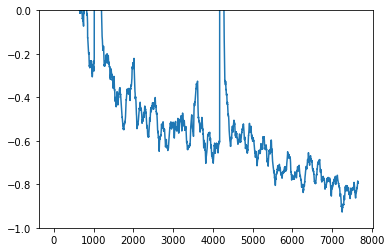

In [102]:
plt.plot(smooth(loss_values, k=100))
plt.ylim(-1, 0)

In [103]:
def smooth(l, k=25):
    return [np.mean(l[t:t+k]) for t in range(len(l) - k)]

<function __main__.smooth>

In [38]:
start_particles = sess.run(mu + noise * tf.exp(log_sigma), {inp: x_train[ind, :]})
samples_ = np.copy(start_particles)

final_samples_list = []
 
for t in range(2000):
    Lx_, px_ = sess.run([Lx, px], {x: samples_, aux: x_train[ind, :]})
    samples_ = accept(samples_, Lx_, px_)

    final_samples_list.append(np.copy(samples_))

In [39]:
F = np.array(final_samples_list)

In [40]:
F.shape

(2000, 128, 12)

In [45]:
def auto_correlation_time(x, s, mu, var):
    b, t, d = x.shape
    act_ = np.zeros([d])
    for i in range(0, b):
        y = x[i] - mu[i]
        p, n = y[:-s], y[s:]
        act_ += np.mean(p * n, axis=0) / var
    act_ = act_ / b
    return act_

In [90]:
F_conv = F[1000:, :, :]

In [89]:
print 'alive?'

alive?


In [91]:
mu = F_conv.mean(axis=0)

In [92]:
mu.shape

(128, 12)

In [48]:
FF = np.transpose(F_conv, (1, 0, 2))

In [50]:
plt.plot([auto_correlation_time(FF, t, mu, 1.) for t in range(500)])

ValueError: operands could not be broadcast together with shapes (0,12) (1000,12) 

In [51]:
signal = F_conv[:, 0, :]

centered_signal = signal - np.mean(signal, axis=0)

In [52]:
centered_signal.shape

(1000, 12)

In [53]:
ft_signal = np.fft.fftn(centered_signal)

In [54]:
powerSpectralDensity = np.abs(ft_signal)**2
autocovariance = np.fft.ifftn(powerSpectralDensity) / len(centered_signal)

In [55]:
autocovariance = np.real(autocovariance)

In [56]:
autocovariance.shape

(1000, 12)

In [58]:
p = np.linalg.norm(autocovariance, axis=1)

In [59]:
p.shape

(1000,)

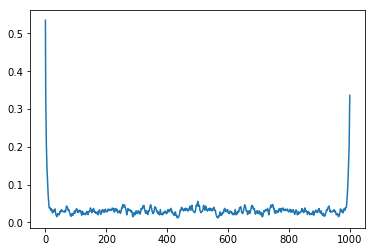

In [60]:
plt.plot(p)

In [76]:
def autocovariance(X, tau=0):
    dT, dN, dX = np.shape(X)
    s = 0.
    for t in range(dT - tau):
        x1 = X[t, :, :]
        x2 = X[t+tau, :, :]

        s += np.trace(x1.dot(x2.T)) / dN

    return s / (dT - tau)

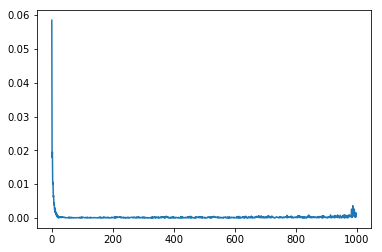

In [67]:
plt.plot(np.abs([autocovariance(F_conv - mu, tau=t) for t in range(999)]))

In [69]:
with tf.variable_scope('hmc_sampler6'):
    hmc_dynamics = Dynamics(x_dim, energy, T=10, eps=0.1, hmc=True, eps_trainable=False, use_temperature=False)

x_hmc = tf.placeholder(tf.float32, shape=(None, 12))
Lx_hmc, _, p_x_hmc = hmc_dynamics.forward(x_hmc, aux=aux)

aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there
aux there


In [70]:
sess.run(tf.variables_initializer(var_from_scope('hmc_sampler6')))

Instructions for updating:
Use `tf.variables_initializer` instead.


In [73]:
samples_ = np.copy(start_particles)

hmc_samples_list = []
 
for t in range(2000):
    Lx_, px_ = sess.run([Lx_hmc, p_x_hmc], {x_hmc: samples_, aux: x_train[ind, :]})
    samples_ = accept(samples_, Lx_, px_)

    hmc_samples_list.append(np.copy(samples_))

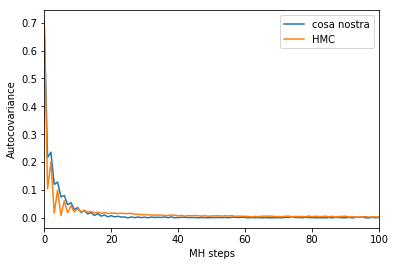

In [95]:
G = np.array(hmc_samples_list)[1000:, :, :]
plt.plot(np.abs([autocovariance(F_conv - mu, tau=t) for t in range(999)]), label='cosa nostra')
plt.plot(np.abs([autocovariance(G - mu, tau=t) for t in range(999)]), label='HMC')
plt.xlim(0, 100)
plt.xlabel('MH steps')
plt.ylabel('Autocovariance')
plt.legend()

In [78]:
np.mean(G, axis=0)[0]

array([ 0.1706972 , -0.43266033, -0.87561742,  1.71988317, -1.33437561,
        1.63003337, -0.16605591, -0.23247811, -0.54360363, -0.37592683,
        1.59473853,  0.00557079])

In [79]:
np.mean(F_conv, axis=0)[0]

array([ 0.17655646, -0.44286594, -0.88104573,  1.70873846, -1.33587713,
        1.64337355, -0.15587746, -0.24919004, -0.54928921, -0.37966474,
        1.56712239, -0.01853508])

In [80]:
z_eval = tf.random_normal((64, 12))
x_eval = tf.nn.sigmoid(decoder(z_eval))

In [81]:
S = sess.run(x_eval)

In [82]:
S = np.reshape(S, (-1, 28, 28))
print S.shape

(64, 28, 28)


In [84]:
def plot_grid(S, width=8):
    sheet_width = width
    plt.figure(figsize=(8, 8))
    for i in xrange(S.shape[0]):
        plt.subplot(sheet_width, sheet_width, i + 1)
        plt.imshow(S[i], cmap='gray')
        plt.grid('off')
        plt.axis('off')

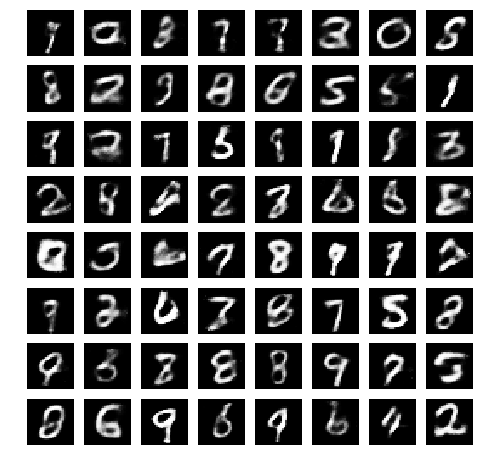

In [85]:
plot_grid(S)

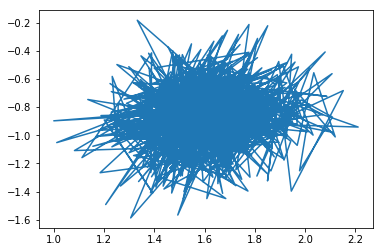

In [101]:
plt.plot(G[:, 0, np.random.choice(12)], G[:, 0, np.random.choice(12)])

In [99]:
i = np.random.choice(12)
i

2

In [ ]:
R